In [285]:
import pandas as pd
import numpy as np
from pathlib import Path
import math
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

## Clean Data, Computed Expected Scores using Log Probs, Impute Missing Values

In [291]:
cwd = Path.cwd()
repo_root = cwd.parent
df = pd.read_csv(repo_root / "data" / "results" / "logprob_responses.csv")
data = pd.read_csv(repo_root / "data" / "survey" / "vignettes_short.csv")

def compute_expected_value(raw_output):
    """
    Given a nested dictionary from the 'Raw Output' column,
    search through the "content" list (under logprobs) to find the first token
    that consists solely of allowed digits: "0", "1", "2", "3", or "4".
    Then compute the expected value using the exponentiated log probabilities from that token's top_logprobs.

    Returns:
        float: The expected value, or None if no appropriate token is found or structure is missing.
    """
    try:
        choices = raw_output.get("choices", [])
        if not choices:
            return None

        first_choice = choices[0]
        logprobs = first_choice.get("logprobs")
        if not logprobs:
            return None

        content = logprobs.get("content", [])
        if not content:
            return None

        allowed_tokens = {"0", "1", "2", "3", "4"}
        candidate = None

        # Iterate through each token in content to find one that consists solely of allowed digits.
        for token_dict in content:
            token_str = token_dict.get("token", "").strip()
            # Check if token_str is nonempty and all characters are among the allowed digits.
            if token_str and all(ch in allowed_tokens for ch in token_str):
                candidate = token_dict
                break

        if candidate is None:
            return None

        top_logprobs = candidate.get("top_logprobs")
        if not top_logprobs:
            return None

        total_prob = 0.0
        weighted_sum = 0.0

        # Compute the weighted sum of the allowed token values.
        for entry in top_logprobs:
            cand_token = entry.get("token", "").strip()
            if cand_token in allowed_tokens:
                prob = math.exp(entry["logprob"])
                weighted_sum += int(cand_token) * prob
                total_prob += prob

        if total_prob == 0:
            return None

        return weighted_sum / total_prob

    except Exception as e:
        return None

# Conver raw output column to a string
df['Raw Output Dict'] = df['Raw Output'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else {})

# Apply the helper function to the 'Raw Output' column and create a new column 'expected_value'
df["Expected Value Answer"] = df["Raw Output Dict"].apply(compute_expected_value)

# Fill NA values with exact ratings
df['Expected Value Answer'] = df['Expected Value Answer'].fillna(df['Answer'])

# Drop unnecessary columns
df = df.drop(columns = ['Raw Output', 'Raw Output Dict'])

df = df.merge(data, on='Scenario')

df['Answer'] = df['Answer'].astype(float)
df['Expected Value Answer'] = df['Expected Value Answer'].astype(float)

df['Expected Value Answer'] = df.groupby(['Service', 'Foundation', 'Model'])['Expected Value Answer'].transform(lambda x: x.fillna(x.mean())).astype(float)
df['Answer'] = df.groupby(['Service', 'Foundation', 'Model'])['Answer'].transform(lambda x: x.fillna(x.mean())).astype(float)

df.loc[df['Model'] == "grok-3-beta", 'Model'] = "grok-3"
df.loc[df['Model'] == "grok-2-1212", 'Model'] = "grok-2"


In [292]:
sample_df = pd.read_csv(repo_root / "data" / "results" / "sampled_responses.csv")
# drop Raw Output column
sample_df = sample_df.drop(columns = ['Raw Output'])
sample_df.loc[sample_df['Service'] == "deep_infra", 'Service'] = "meta"
sample_df.loc[sample_df['Model'] == "gpt-4.5-preview", 'Model'] = "gpt-4.5"
sample_df.loc[sample_df['Model'] == "gemini-2.5-flash-preview-04-17", 'Model'] = "gemini-2.5-flash"
sample_df.loc[sample_df['Model'] == "gemini-2.5-pro-preview-03-25", 'Model'] = "gemini-2.5-pro"
sample_df.loc[sample_df['Model'] == "claude-3-5-sonnet-20241022", 'Model'] = "claude-3.5-sonnet"
sample_df.loc[sample_df['Model'] == "claude-3-7-sonnet-20250219", 'Model'] = "claude-3.7-sonnet"
sample_df.loc[sample_df['Model'] == "claude-3-5-haiku-20241022", 'Model'] = "claude-3.5-haiku"
sample_df.loc[sample_df['Model'] == "claude-3-opus-20240229", 'Model'] = "claude-3-opus"
sample_df.loc[sample_df['Model'] == "meta-llama/Meta-Llama-3.1-405B-Instruct", 'Model'] = "llama-3.1-405B"
sample_df.loc[sample_df['Model'] == "meta-llama/Meta-Llama-3.1-70B-Instruct", 'Model'] = "llama-3.1-70B"
sample_df.loc[sample_df['Model'] == "meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8", 'Model'] = "llama-4-Maverick"
sample_df.loc[sample_df['Model'] == "meta-llama/Llama-4-Scout-17B-16E-Instruct", 'Model'] = "llama-4-scout"
sample_df.loc[sample_df['Model'] == "deepseek-chat", 'Model'] = "deepseek-v3"
sample_df.loc[sample_df['Model'] == "deepseek-reasoner", 'Model'] = "deepseek-r1"

sample_df['Expected Value Answer'] = sample_df['Answer'].astype(float)
# drop llama maverick
sample_df = sample_df[sample_df['Model'] != "llama-4-Maverick"]
# join with scenario data
sample_df = sample_df.merge(data, on='Scenario')
# filter df to include only the models not in sample_df
df = df[~df['Model'].isin(sample_df['Model'])]
# concatenate df and sample_df
df = pd.concat([df, sample_df], ignore_index=True)
# sort by Service, Foundation, Model
df = df.sort_values(by=['Service', 'Foundation', 'Model'])

df['Expected Value Answer'] = df.groupby(['Service', 'Foundation', 'Model'])['Expected Value Answer'].transform(lambda x: x.fillna(x.mean())).astype(float)

df.to_csv(repo_root / "data" / "results" / "cleaned_model_responses.csv", index=False)

## Plot Foundation Means and Confidence Intervals by Model Provider

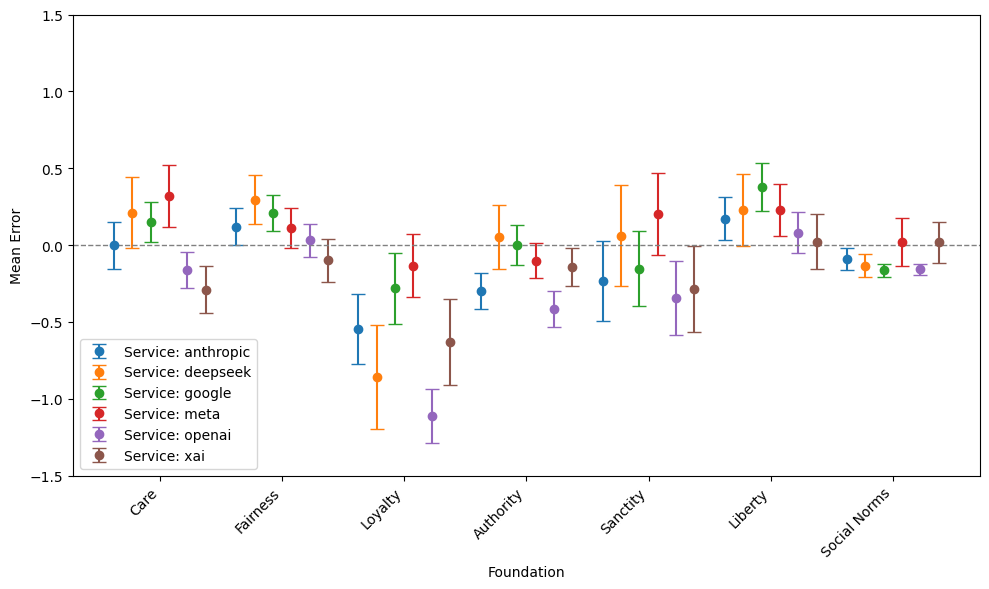

In [290]:
# Append human responses to model data
df['Error'] = df['Expected Value Answer'] - df['Wrong']

toggle_show_all = True  # Change to True to plot all foundations

# Specify which foundation to display when toggle is set to False
chosen_foundation = "Loyalty"

# Define the custom order for foundations
foundations_order = ['Care', 'Fairness', 'Loyalty', 'Authority', 'Sanctity', 'Liberty', 'Social Norms']
foundations = sorted(df['Foundation'].unique(), key=foundations_order.index)

# Get the unique services (or models) from the "Service" column
models = df['Service'].unique()

# Map each foundation to a fixed x-axis position; these positions remain regardless of toggle state
x_positions = np.arange(len(foundations))
offset_width = 0.15  # Spacing offset for multiple models within the same foundation

# Create the figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Loop over each service/model and calculate statistics for each foundation
for j, model in enumerate(models):
    means = []
    errors = []  # We'll use the 95% confidence interval (1.96 * SEM) here
    for foundation in foundations:
        # Depending on the toggle, either include all foundations or only the chosen one
        if toggle_show_all or foundation == chosen_foundation:
            scores = df[(df['Foundation'] == foundation) & (df['Service'] == model)]['Error']
            mean_score = scores.mean()
            ci = 1.96 * scores.sem()  # 95% confidence interval
            means.append(mean_score)
            errors.append(ci)
        else:
            # For foundations not selected, use np.nan so that nothing is plotted.
            means.append(np.nan)
            errors.append(0)
    means = np.array(means)
    errors = np.array(errors)

    # Compute the x-offset for each model so that markers don't overlap at the same foundation position.
    x_offset = x_positions - (offset_width * (len(models) - 1) / 2) + j * offset_width

    # Plot markers with error bars (without connecting lines; fmt='o' plots markers only)
    ax.errorbar(x_offset, means, yerr=errors, fmt='o', capsize=5, label=f"Service: {model}")

# Set x-axis ticks and labels; all foundations are shown even if no data is plotted for some.
ax.set_xticks(x_positions)
ax.set_xticklabels(foundations, rotation=45, ha='right')
ax.set_xlabel("Foundation")
ax.set_ylabel("Mean Error")
ax.legend(loc="lower left")

# Set y-axis limits based on the full data range so it remains constant whether one or all foundations are shown.
y_min = -1.5
y_max = 1.5
ax.set_ylim(y_min, y_max)

# add a dashed line at y=0
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

# save to plots folder
fig.savefig(repo_root / "plots" / "mean_diffs.png", dpi=300, bbox_inches='tight')

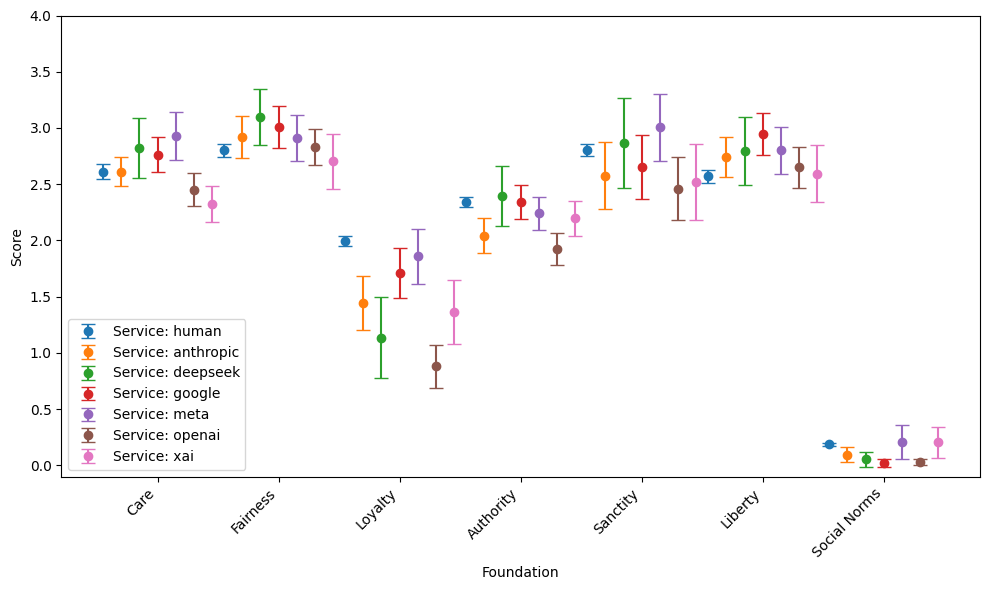

In [267]:
# Append human responses to model data
human_df = df[['Scenario', 'Foundation', 'Wrong']].copy()
human_df = human_df.rename(columns={"Wrong": "Expected Value Answer"})
human_df.loc[:, 'Service'] = "human"
human_df.loc[:, 'Model'] = "human-subjects"
joint_df = pd.concat([human_df, df])

toggle_show_all = True  # Change to True to plot all foundations

# Specify which foundation to display when toggle is set to False
chosen_foundation = "Loyalty"

# Define the custom order for foundations
foundations_order = ['Care', 'Fairness', 'Loyalty', 'Authority', 'Sanctity', 'Liberty', 'Social Norms']
foundations = sorted(joint_df['Foundation'].unique(), key=foundations_order.index)

# Get the unique services (or models) from the "Service" column
models = joint_df['Service'].unique()

# Map each foundation to a fixed x-axis position; these positions remain regardless of toggle state
x_positions = np.arange(len(foundations))
offset_width = 0.15  # Spacing offset for multiple models within the same foundation

# Create the figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Loop over each service/model and calculate statistics for each foundation
for j, model in enumerate(models):
    means = []
    errors = []  # We'll use the 95% confidence interval (1.96 * SEM) here
    for foundation in foundations:
        # Depending on the toggle, either include all foundations or only the chosen one
        if toggle_show_all or foundation == chosen_foundation:
            scores = joint_df[(joint_df['Foundation'] == foundation) & (joint_df['Service'] == model)]['Expected Value Answer']
            mean_score = scores.mean()
            ci = 1.96 * scores.sem()  # 95% confidence interval
            means.append(mean_score)
            errors.append(ci)
        else:
            # For foundations not selected, use np.nan so that nothing is plotted.
            means.append(np.nan)
            errors.append(0)
    means = np.array(means)
    errors = np.array(errors)

    # Compute the x-offset for each model so that markers don't overlap at the same foundation position.
    x_offset = x_positions - (offset_width * (len(models) - 1) / 2) + j * offset_width

    # Plot markers with error bars (without connecting lines; fmt='o' plots markers only)
    ax.errorbar(x_offset, means, yerr=errors, fmt='o', capsize=5, label=f"Service: {model}")

# Set x-axis ticks and labels; all foundations are shown even if no data is plotted for some.
ax.set_xticks(x_positions)
ax.set_xticklabels(foundations, rotation=45, ha='right')
ax.set_xlabel("Foundation")
ax.set_ylabel("Score")
ax.legend(loc="lower left")

# Set y-axis limits based on the full data range so it remains constant whether one or all foundations are shown.
y_min = joint_df['Expected Value Answer'].min() - 0.1
y_max = joint_df['Expected Value Answer'].max()
ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

## Plot Spearman's Correlation Matrix Across Foundations

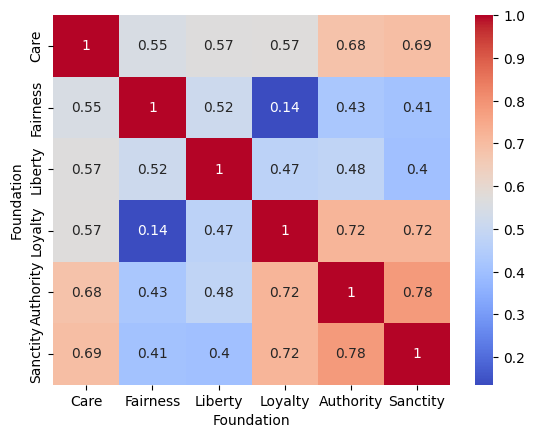

In [275]:
# Group data by foundation and model and calculate mean score
group_df = df.groupby(['Foundation', 'Model']).agg({'Expected Value Answer' : 'mean'}).reset_index()
group_df = group_df.loc[group_df['Foundation'] != "Social Norms"]
wide_df = group_df.pivot(index="Model", columns="Foundation", values="Expected Value Answer")

desired_order = ["Care", "Fairness", "Liberty", "Loyalty", "Authority", "Sanctity"]

# use spearman's rank correlation to measure inter-foundation relationship
corr_matrix = wide_df.corr(method='spearman')
ordered_corr_matrix = corr_matrix.reindex(index=desired_order, columns=desired_order)
heatmap = sns.heatmap(ordered_corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# save to plots folder
heatmap.figure.savefig(repo_root / "plots" / "corr_matrix.png", dpi=300, bbox_inches='tight')


## Plot PCA Scores and Average Foundation Loadings

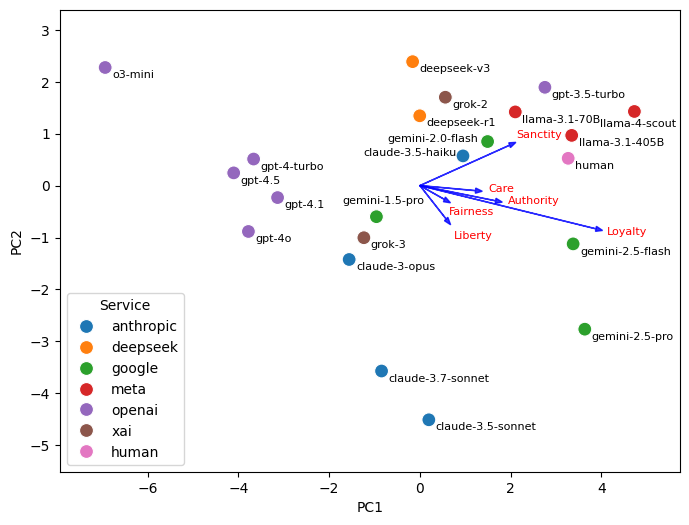

In [269]:
# Remove social norms from model data
no_norms_df = df.loc[~df['Foundation'].isin(["Social Norms"])]

# Creata dataframe of human responses and append it to model data without social norms
human_df = data.loc[~data['Foundation'].isin(['Social Norms'])].copy()
human_df = human_df.drop(columns=['Foundation', 'Care', 'Fairness', 'Loyalty', 'Authority', 'Sanctity', 'Liberty', 'Not Wrong'])
human_df['Model'] = "human"
human_df['Service'] = "human"
human_df = human_df.rename(columns={"Wrong": "Expected Value Answer"})
composite_df = no_norms_df[['Scenario', 'Expected Value Answer', 'Service', 'Model']].copy()
composite_df = pd.concat([human_df, no_norms_df])

# Pivot data so that responses are rows and questions are columns
pivot_df = composite_df.pivot(index="Model", columns="Scenario", values="Expected Value Answer")
pivot_df = pivot_df.apply(lambda row: row.fillna(row.mean()), axis=1)

# Run PCA on this matrix
X = pivot_df.values
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
pca_df = pd.DataFrame(data=X_reduced, index=pivot_df.index, columns=["PC1", "PC2"])

# Retrieve model service info
model_service = composite_df[['Model', 'Service']].drop_duplicates().set_index('Model')
pca_df = pca_df.join(model_service['Service'])

# Create a DataFrame of loadings from the PCA components.
loadings = pd.DataFrame(pca.components_.T,
                        index=pivot_df.columns,
                        columns=["PC1", "PC2"])

# Merge loadings with scenario information
loadings_with_foundation = loadings.merge(data, left_index=True, right_on="Scenario")

# Average the loadings by Foundation.
avg_loadings = loadings_with_foundation.groupby("Foundation")[["PC1", "PC2"]].mean().reset_index()

desired_order = ["anthropic",  "deepseek", "google", "meta", "openai", "xai", "human"]

# Convert the "Service" column into a categorical type with the desired order.
pca_df["Service"] = pd.Categorical(pca_df["Service"], categories=desired_order, ordered=True)

# Create scatterplot with options to show scores or loadings
fig, ax = plt.subplots(figsize=(8, 6))

# Comment the following lines if you want to just plot the loadings
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Service", s=100, ax=ax)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend(title="Service")

for model_name, row in pca_df.iterrows():
    if model_name == "gemini-2.0-flash" or model_name == "claude-3.5-haiku":
      ax.text(row["PC1"] - 2.2, row["PC2"], model_name, fontsize=8)
    elif model_name == "llama-4-scout":
      ax.text(row["PC1"] - 0.75, row["PC2"] - 0.3, model_name, fontsize=8)
    elif model_name == "gemini-1.5-pro":
      ax.text(row["PC1"] - 0.75, row["PC2"] + 0.25, model_name, fontsize=8)
    else:
      ax.text(row["PC1"] + 0.15, row["PC2"] - 0.2, model_name, fontsize=8)



# Calculate the axis limits based on the PCA data (with a margin)
margin = 1.0
x_min, x_max = pca_df["PC1"].min() - margin, pca_df["PC1"].max() + margin
y_min, y_max = pca_df["PC2"].min() - margin, pca_df["PC2"].max() + margin
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Define a scaling factor for the loading vectors
loading_scale = 25  # Adjust this to control arrow length

# Overlay scaled arrows (vectors) for each averaged foundation loading
for i, row in avg_loadings.iterrows():
    # Apply the scaling factor.
    pc1_scaled = row["PC1"] * loading_scale
    pc2_scaled = row["PC2"] * loading_scale

    # Draw an arrow from the origin (0,0) to the scaled loading coordinates
    ax.arrow(0, 0, pc1_scaled, pc2_scaled,
             color='blue', width=0.005, head_width=0.1,
             length_includes_head=True, alpha=0.8)

    # Calculate default label positions
    label_x = pc1_scaled * 1.1
    label_y = pc2_scaled * 1.1

    # Manual adjustment of foundation labels
    if row["Foundation"].strip().lower() == "care":
        label_y = label_y

    if row["Foundation"].strip().lower() == "fairness":
        label_y = label_y - 0.2 # adjust this value as needed
        label_x = label_x - 0.1

    if row["Foundation"].strip().lower() == "liberty":
        label_y = label_y - 0.2 # adjust this value as needed

    if row["Foundation"].strip().lower() == "loyalty":
        label_x = label_x - 0.3 # adjust this value as needed

    if row["Foundation"].strip().lower() == "authority":
        label_y = label_y # adjust this value as needed
        label_x = label_x - 0.05

    if row["Foundation"].strip().lower() == "sanctity":
        label_y = label_y # adjust this value as needed
        label_x = label_x - 0.2

    # Add foundation labels next to vectors
    ax.text(label_x, label_y, row["Foundation"], color='red', fontsize=8)

# Save to plots folder
fig.savefig(repo_root / "plots" / "pca_biplot.png", dpi=300, bbox_inches='tight')

## Load Text Embeddings Data and Plot Standardized Foundation Means

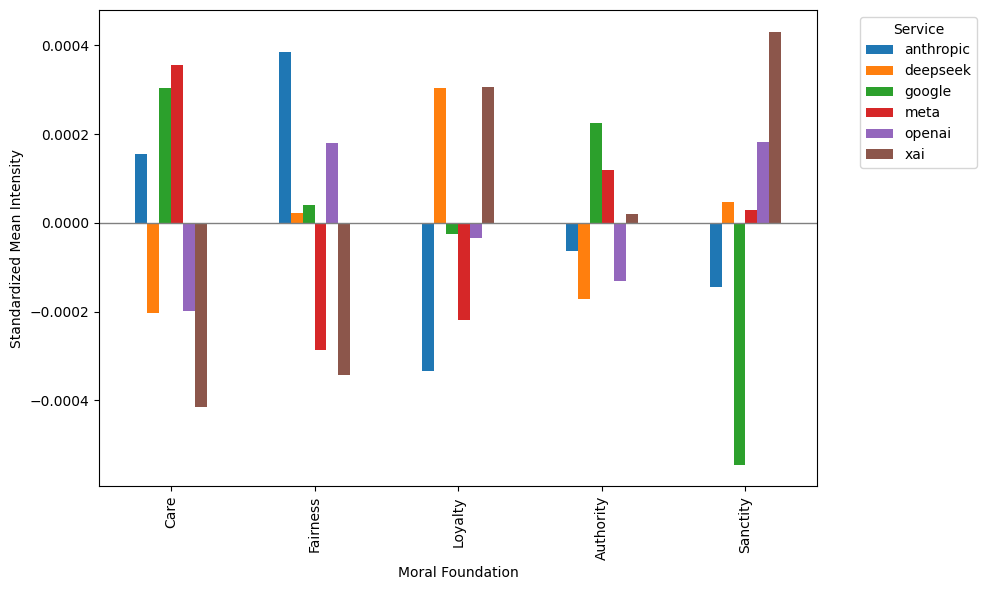

In [283]:
# Load data on foundation intensity by question
mfd_scores = pd.read_csv(repo_root / "data/embeddings/emfd_scores.csv")

# Remove questions and models lacking foundation intensity data (no liberty included)
mfd_scores = mfd_scores.loc[mfd_scores['Model'] != "gemini-2.0-flash"]
mfd_scores = mfd_scores.loc[~mfd_scores['Foundation'].isin(["Liberty", "Social Norms"])]
mfd_scores = mfd_scores.loc[~pd.isna(mfd_scores['Comment'])]

# Limit to questions with data for each model in the sample
all_models = mfd_scores['Model'].unique()
scenario_counts = mfd_scores.groupby('Scenario')['Model'].nunique()
filtered_scenarios = scenario_counts[scenario_counts == len(all_models)].index
mfd_scores = mfd_scores[mfd_scores['Scenario'].isin(filtered_scenarios)]

# Group by model provider and calculate survey average for intensity for each foundation
agg_df = mfd_scores.groupby(['Service']).agg({'intensity_authority':'mean', 'intensity_fairness':'mean', 'intensity_care':'mean', 'intensity_loyalty': 'mean', 'intensity_sanctity' : 'mean'}).reset_index()

# assume agg_df has columns: Service, intensity_authority, ..., intensity_sanctity
cols = ['intensity_authority','intensity_fairness','intensity_care',
        'intensity_loyalty','intensity_sanctity']
text_df = agg_df.copy()

# 1. compute means
provider_mean   = text_df[cols].mean(axis=1)                      # μ_p
foundation_mean = text_df[cols].mean(axis=0)                      # μ_f
grand_mean      = text_df[cols].values.mean()                    # μ

# 2. double-center
df_centered = (
    text_df[cols]
      .sub(provider_mean,   axis=0)  # subtract μ_p from each row
      .sub(foundation_mean, axis=1)  # subtract μ_f from each column
      .add(grand_mean)               # add back μ
)

# 3. pivot for plotting
df_plot = df_centered.copy()
df_plot.index = text_df['Service']
df_plot = df_plot.T
df_plot.index = df_plot.index.str.replace("intensity_", "").str.capitalize()
ordered = ["Care","Fairness","Loyalty","Authority","Sanctity"]
df_plot = df_plot.loc[ordered]

# 4. plot
ax = df_plot.plot(kind='bar', figsize=(10,6))
ax.set_xlabel("Moral Foundation")
ax.set_ylabel("Standardized Mean Intensity")
ax.axhline(0, color='gray', linewidth=1)
plt.legend(title="Service", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# save to plots folder
fig = ax.get_figure()
fig.savefig(repo_root / "plots" / "embeddings.png", dpi=300, bbox_inches='tight')

## Plot Clusters for Model by Cosine Similarity of Average Question Embedding

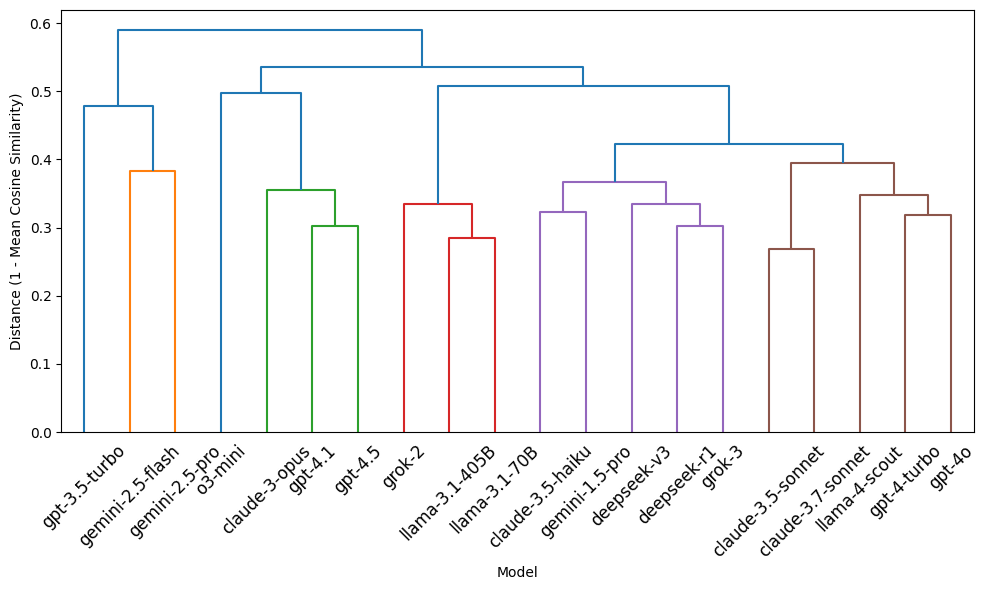

In [250]:
models = sorted(mfd_scores['Model'].unique())

embedding_columns = [col for col in mfd_scores.columns if col.startswith(('bias', 'intensity'))]

# Create DataFrames to accumulate the sum of cosine similarities and counts of comparisons
similarity_sum = pd.DataFrame(0.0, index=models, columns=models)
similarity_count = pd.DataFrame(0, index=models, columns=models)

# Group by question (using the 'Scenario' column)
for scenario, group in mfd_scores.groupby('Scenario'):
    # For each question, group responses by Model.
    # If a model provided more than one response for the same question,
    # take the average embedding.
    model_embeddings = group.groupby('Model')[embedding_columns].mean()

    # List of models that have a response for this question
    scenario_models = model_embeddings.index.tolist()

    # Skip questions with fewer than two responding models
    if len(scenario_models) < 2:
        continue

    # Get the embeddings as a matrix: shape (# models for this question, embedding_dim)
    X = model_embeddings.values

    # Compute pairwise cosine similarity between responses in this question
    sim_matrix = cosine_similarity(X)  # shape: (# models, # models)

    # Iterate over each pair of models in this scenario and accumulate their similarities.
    for i, model_i in enumerate(scenario_models):
        for j, model_j in enumerate(scenario_models):
            # Optionally, you can skip self-comparisons (which are always 1).
            if model_i != model_j:
                similarity_sum.loc[model_i, model_j] += sim_matrix[i, j]
                similarity_count.loc[model_i, model_j] += 1

# Compute the average cosine similarity by dividing the cumulative sum by the counts.
# Replace zeros in counts with NaN to avoid division by zero.
avg_similarity = similarity_sum / similarity_count.replace(0, np.nan)

# Replace any NaN values with 0 (or an appropriate value) in your similarity matrix.
# Then convert the similarity matrix to a distance matrix.
distance = 1 - avg_similarity.fillna(0)

# Make sure the distance matrix is symmetric.
distance = (distance + distance.T) / 2

# Convert the square distance matrix to a condensed distance matrix.
dist_condensed = squareform(distance, checks=False)

# Perform hierarchical clustering using a linkage method such as 'average' or 'ward'.
Z = linkage(dist_condensed, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(Z, labels=avg_similarity.index.tolist(), leaf_rotation=45)
plt.xlabel('Model')
plt.ylabel('Distance (1 - Mean Cosine Similarity)')
plt.tight_layout()
plt.show()


## Appendix: Rotated Kernel Density Plot of Foundation Means

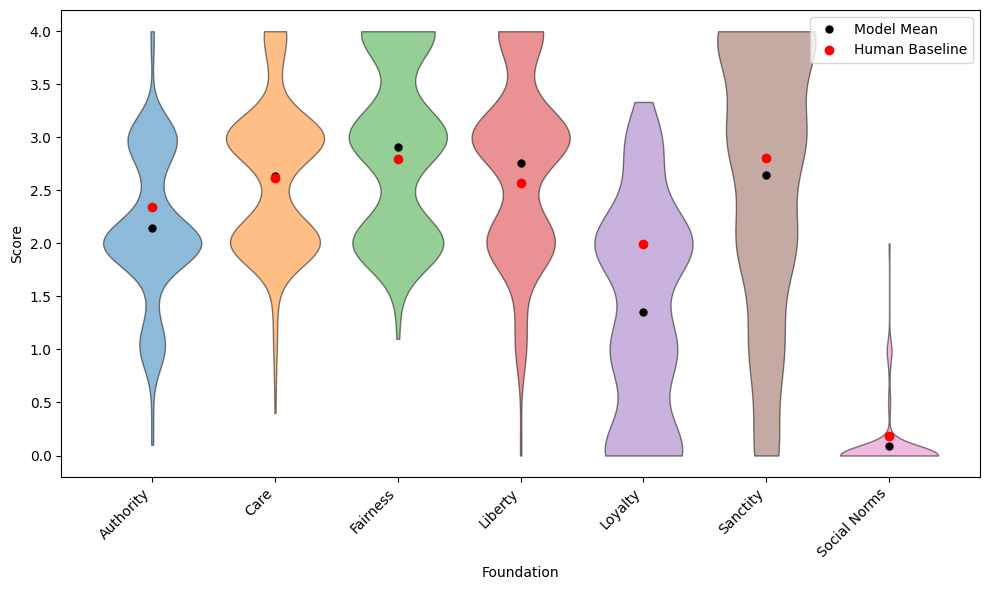

In [251]:
# Get sorted list of unique foundations
foundations = sorted(df['Foundation'].unique())

fig, ax = plt.subplots(figsize=(10, 6))

# Maximum horizontal width for each density plot (controls "violin" width)
max_width = 0.4

# Calculate the human baseline averages per foundation for overlay (from 'Wrong' column)
human_avgs = df.groupby('Foundation')['Wrong'].mean().reindex(foundations)

# Loop through each foundation and plot the density for model responses
for i, foundation in enumerate(foundations):
    # Select model responses for the current foundation
    scores = df[df['Foundation'] == foundation]['Expected Value Answer']

    # Compute the density using gaussian_kde over an appropriate range
    y = np.linspace(scores.min(), scores.max(), 100)
    density = gaussian_kde(scores)
    dens_values = density(y)

    # Scale density so that the maximum width is max_width
    dens_scaled = dens_values / dens_values.max() * max_width

    # Plot the density horizontally centered at the position i using fill_betweenx
    ax.fill_betweenx(y, i - dens_scaled, i + dens_scaled, alpha=0.5, edgecolor='black')

    # Optionally, mark the mean model response for the foundation
    mean_score = scores.mean()
    if i == 0:
        ax.plot(i, mean_score, 'ko', markersize=5, label="Model Mean")
    else:
        ax.plot(i, mean_score, 'ko', markersize=5)

# Overlay human baseline averages as red dots for each foundation
ax.plot(np.arange(len(foundations)), human_avgs, 'ro', label='Human Baseline')

# Set foundation labels on the x-axis
ax.set_xticks(np.arange(len(foundations)))
ax.set_xticklabels(foundations, rotation=45, ha="right")
ax.set_xlabel("Foundation")
ax.set_ylabel("Score")
ax.legend()

plt.tight_layout()
plt.show()